## Data Gathering

### Data info
The data we use is based on King County data which has geolocation. This data has been collected in 2014-2015
id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
- id - house ID
- date - sell date
- price - sell price
- bedrooms - no of bedrooms
- bathrooms - no of bathrooms(A bathroom without any shower or van is considered 0.5)
- sqft_living - usable interior space
- sqft_lot - the space of the land(Not sure so dropped, dataset didnt have any explinations on Kaggle)
- floors - no of floors
- waterfront - ?
- view - ?
- condition - house overall condition
- grade - ?
- sqft_above - ?
- sqft_basement - basement space
- yr_built,yr_renovated - years for construction and renovation
- zipcode,lat,long - geolocation

### Data mods
First of all we want to remodel the dataset:
- Drop unuseful columns from dataset
- Convert in eur currency/measure units



In [ ]:
import pandas as pd

def convert_sqft_to_sqm(value):
    return value * 0.092903

def convert_dollars_to_euros(value):
    return value * 0.92

df = pd.read_csv('../data/kc_house_data.csv')  

# Drop the columns that are not useful for the analysis: sqm_lot,waterfront,view,sqm_above,sqm_basement,zipcode

columns_to_drop = ['id','date','sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'zipcode']

df.drop(columns=columns_to_drop, inplace=True)

# Convert the columns from sqft to sqm and from dollars to euros
df['sqft_living'] = df['sqft_living'].apply(convert_sqft_to_sqm)
df['price'] = df['price'].apply(convert_dollars_to_euros)

new_column_names = {
    'sqft_living': 'sqm_living',
}
df.rename(columns=new_column_names, inplace=True)

df.to_csv('../data/prefinal_dataset.csv', index=False)

print("Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.")

#### Now we have to create and colect info about every graph to take the measurements on based on lat and long

Access to function: <function clustering_coef at 0x0000019BEC8E4670>


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:19: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


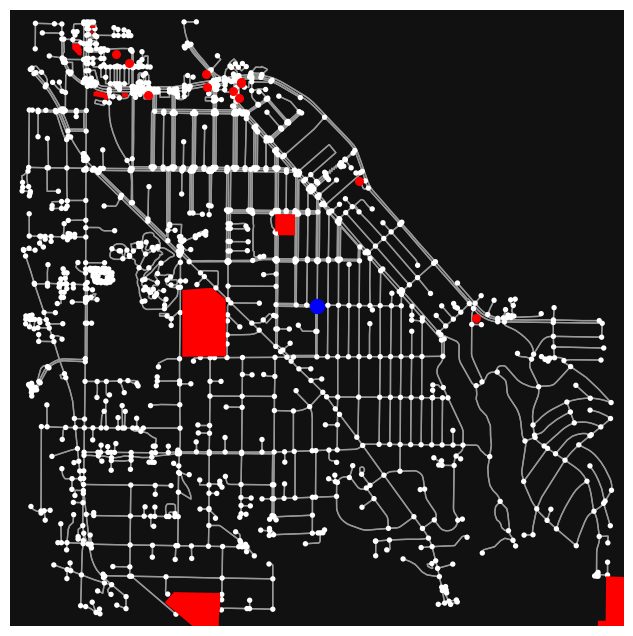

                                   alt_name     amenity  atm      brand  \
element_type osmid                                                        
node         2156871565  Washington Federal        bank  yes  WaFd Bank   
             2446638577                 NaN  restaurant  NaN        NaN   
             2446638590                 NaN        cafe  NaN        NaN   
             2446638616                 NaN  restaurant  NaN        NaN   
             5730670747                 NaN        cafe  NaN  Starbucks   

                        brand:wikidata drive_through               name  \
element_type osmid                                                        
node         2156871565       Q7971859           yes          WaFd Bank   
             2446638577            NaN           NaN  Drae's Lake Route   
             2446638590            NaN           NaN       Redwing Cafe   
             2446638616            NaN           NaN   Rainier Crawfish   
             5730670747 

In [2]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sklearn

import sys
import os

utils_path = os.path.join(os.getcwd(), '..', 'utils')  # Assumes utils is one directory up from the script
sys.path.append(utils_path)
# Import utils file
from utils import clustering_coef

# Test if the function can be accessed
print("Access to function:", clustering_coef)

# Set up configuration for osmnx
ox.config(use_cache=True, log_console=True)

# Function to fetch points of interest and graph
def fetch_pois(lat, lon, dist=1250, network_type='walk', plot=True):
    point = (lat, lon)
    try:
        G = ox.graph_from_point(point, dist=dist, network_type=network_type, simplify=True)
        amenities = [
            'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
            'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
            'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
            'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
            'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
            'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
            'park', 'stadium', 'swimming_pool', 'sports_centre'
        ]
        pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)
        nearest_node = ox.distance.nearest_nodes(G, lon, lat)

    except Exception as e:
        print(f"Error fetching POIs for location ({lat}, {lon}): {e}")
        return None, None, None

    if plot and G is not None:
        fig, ax = ox.plot_graph(G, show=False, close=False)
        pois['geometry'].plot(ax=ax, color='red', markersize=30)
        x, y = G.nodes[nearest_node]['x'], G.nodes[nearest_node]['y']
        ax.scatter(x, y, color='blue', s=100, zorder=5)
        plt.show()
        return G, pois, nearest_node
    return G, pois, nearest_node

# Load your data
df = pd.read_csv('../data/prefinal_dataset.csv')

# Fetch POIs for the first location
lat, lon = df['lat'][0], df['long'][0]
graph, points_of_interest, nearest_node = fetch_pois(lat, lon)
print(points_of_interest.head())  # Display some of the POIs
print("Nearest node:", nearest_node)

# Perform your analysis here
# Average node degree
print("Average node degree:", sum(dict(graph.degree()).values()) / len(graph.nodes))

#measure degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree centrality:", degree_centrality[nearest_node])

# Measure betweenness centrality
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness centrality:", betweenness_centrality[nearest_node])

# Measure closeness centrality
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness centrality:", closeness_centrality[nearest_node])

# Measure graph density and average path length
density = nx.density(graph)
print("Graph density:", density)

#### Doing the example for all samples

!!! DONT START A FULL RUN ON THIS YET

In [3]:
# Load data
df = pd.read_csv('../data/prefinal_dataset.csv')

# Define new columns for graph analysis results
additional_columns = ['avg_degree', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'density']
for column in additional_columns:
    df[column] = None

max_iterations = 2000
start_index = 16  # Adjust this to your preferred starting index

for index, row in df.iterrows():
    if index < start_index:
        continue  # Skip processing until we reach the start index
    if index >= start_index + max_iterations:
        print("Stopped after 2000 iterations")
        break
    
    lat, lon = row['lat'], row['long']
    graph, points_of_interest, nearest_node = fetch_pois(lat, lon, plot=False)
    
    if graph is None or points_of_interest is None or nearest_node is None:
        print(f"Skipping index {index} due to fetch failure")
        continue  # Skip this row due to an error

    # Perform your analysis here
    avg_degree = sum(dict(graph.degree()).values()) / len(graph.nodes)
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    density = nx.density(graph)

    df.at[index, 'avg_degree'] = avg_degree
    df.at[index, 'degree_centrality'] = degree_centrality[nearest_node]
    df.at[index, 'betweenness_centrality'] = betweenness_centrality[nearest_node]
    df.at[index, 'closeness_centrality'] = closeness_centrality[nearest_node]
    df.at[index, 'density'] = density
    print("Done for index:", index)

    # Save the DataFrame to CSV after processing each row
    df.to_csv('../data/final_dataset.csv', index=False)


print("Processing complete. Data saved.")

C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 0


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 1


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 2


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 3


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 4


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Error fetching POIs for location (47.6561, -122.005): No data elements in server response. Check log and query location/tags.
Skipping index 5 due to fetch failure


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 6


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 7


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 8


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 9


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 10


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 11


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 12


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 13


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 14


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


Done for index: 15


C:\Users\PelePC\AppData\Local\Temp\ipykernel_26476\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


KeyboardInterrupt: 